# 1. Preliminary steps

In [1]:
import nltk

In [2]:
from nltk.corpus import state_union, inaugural

To list all documents in a corpus, you can use the `fileids()` method:

In [3]:
print(inaugural.fileids())

['1789-Washington.txt', '1793-Washington.txt', '1797-Adams.txt', '1801-Jefferson.txt', '1805-Jefferson.txt', '1809-Madison.txt', '1813-Madison.txt', '1817-Monroe.txt', '1821-Monroe.txt', '1825-Adams.txt', '1829-Jackson.txt', '1833-Jackson.txt', '1837-VanBuren.txt', '1841-Harrison.txt', '1845-Polk.txt', '1849-Taylor.txt', '1853-Pierce.txt', '1857-Buchanan.txt', '1861-Lincoln.txt', '1865-Lincoln.txt', '1869-Grant.txt', '1873-Grant.txt', '1877-Hayes.txt', '1881-Garfield.txt', '1885-Cleveland.txt', '1889-Harrison.txt', '1893-Cleveland.txt', '1897-McKinley.txt', '1901-McKinley.txt', '1905-Roosevelt.txt', '1909-Taft.txt', '1913-Wilson.txt', '1917-Wilson.txt', '1921-Harding.txt', '1925-Coolidge.txt', '1929-Hoover.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt', '1949-Truman.txt', '1953-Eisenhower.txt', '1957-Eisenhower.txt', '1961-Kennedy.txt', '1965-Johnson.txt', '1969-Nixon.txt', '1973-Nixon.txt', '1977-Carter.txt', '1981-Reagan.txt', '1985-Reaga

To access the content of a given document, you can use the `raw()`, `words()` and `sents()`methods as follows:

In [4]:
print(inaugural.raw('1793-Washington.txt'))
print(inaugural.words('1793-Washington.txt'))
print(inaugural.sents('1793-Washington.txt'))

Fellow citizens, I am again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occasion proper for it shall arrive, I shall endeavor to express the high sense I entertain of this distinguished honor, and of the confidence which has been reposed in me by the people of united America.

Previous to the execution of any official act of the President the Constitution requires an oath of office. This oath I am now about to take, and in your presence: That if it shall be found during my administration of the Government I have in any instance violated willingly or knowingly the injunctions thereof, I may (besides incurring constitutional punishment) be subject to the upbraidings of all who are now witnesses of the present solemn ceremony.

 

['Fellow', 'citizens', ',', 'I', 'am', 'again', ...]
[['Fellow', 'citizens', ',', 'I', 'am', 'again', 'called', 'upon', 'by', 'the', 'voice', 'of', 'my', 'country', 'to', 'execute', 'the', 'functions', 'of', 

# 2. The lm module: basics

In [5]:
from nltk.util import ngrams
from nltk.lm import NgramCounter, Vocabulary

Let’s count all unigrams in the `state_union` corpus:

In [6]:
text_unigrams = [ngrams(sent, 1) for sent in state_union.sents()]
ngram_counts = NgramCounter(text_unigrams)
print(ngram_counts.N())

399829


You can look at the frequencies of a type in a very simple way:

In [7]:
print(ngram_counts['the']) # Unigrapm
print(ngram_counts[['the']]['new']) # Bigram

19191
0


The “unigrams” member is a `FreqDist` object.
Shows the 20 most frequent types. 

In [8]:
ngram_counts.unigrams.most_common(20)
ngram_counts.unigrams.plot(20)

<Figure size 640x480 with 1 Axes>

Vocabulary objects allow to create a vocabulary from a set of types and a frequency threshold.
The vocabulary will include all words that appear at least 2 times in the corpus.

In [9]:
vocab = Vocabulary(state_union.words(), unk_cutoff=2)
print(len(vocab))

9105


## Exercise 1

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def get_ngram_counts(processed_corpus, fileid):
    text_unigrams = [ngrams(sent, 1) for sent in processed_corpus.sents(fileid)]
    ngram_counts = NgramCounter(text_unigrams)
    return ngram_counts.N()

def get_vocab_counts(processed_corpus, fileid):
    vocab = Vocabulary(processed_corpus.words(fileid), unk_cutoff=1)
    return len(vocab)

def get_results(processed_corpus, results_type):
    results = []
    if results_type == "ngrams":
        my_function = get_ngram_counts
    elif results_type == "vocab":
        my_function = get_vocab_counts
    else:
        return None

    for fileid in processed_corpus.fileids():
        res = my_function(processed_corpus, fileid)
        results.append((res, "{} - {} | {}".format(fileid[:4], fileid[5:-4], res)))

    results = sorted(results, reverse=True)
    results, presidents = map(list, zip(*results))

    return presidents, results

def plot_results(presidents, results):   
    plt.rcParams['figure.figsize'] = [20, 6]
    plt.bar(presidents, results)
    plt.xticks(presidents, rotation='vertical')
    plt.show()

    print("Max: {:20s}".format(presidents[0]))
    print("Min: {:20s}".format(presidents[-1]))

def run_exo1(processed_corpus, results_type):
    presidents, results = get_results(processed_corpus, results_type)
    plot_results(presidents, results)



Results for inaugural and ngrams


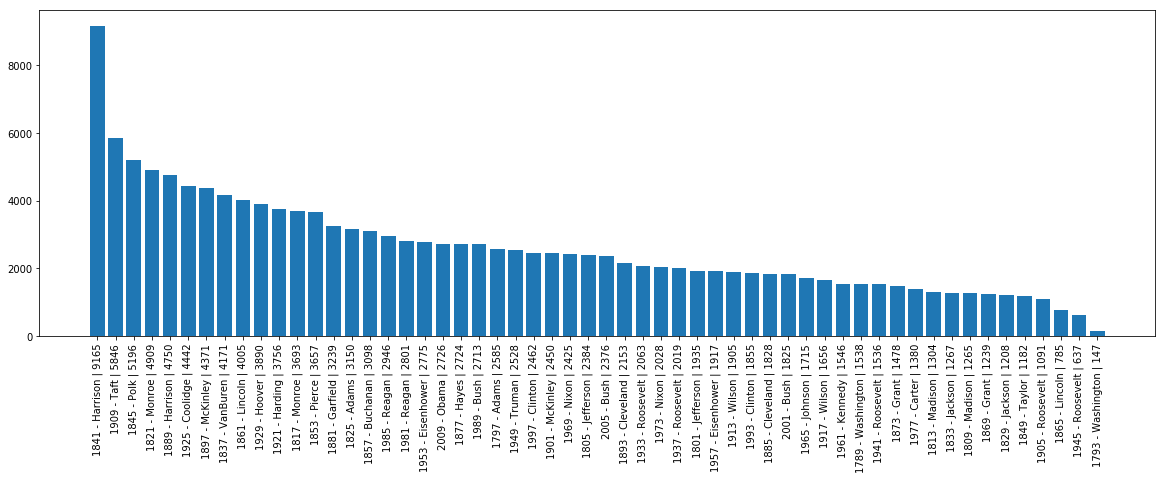

Max: 1841 - Harrison | 9165
Min: 1793 - Washington | 147


Results for inaugural and vocab


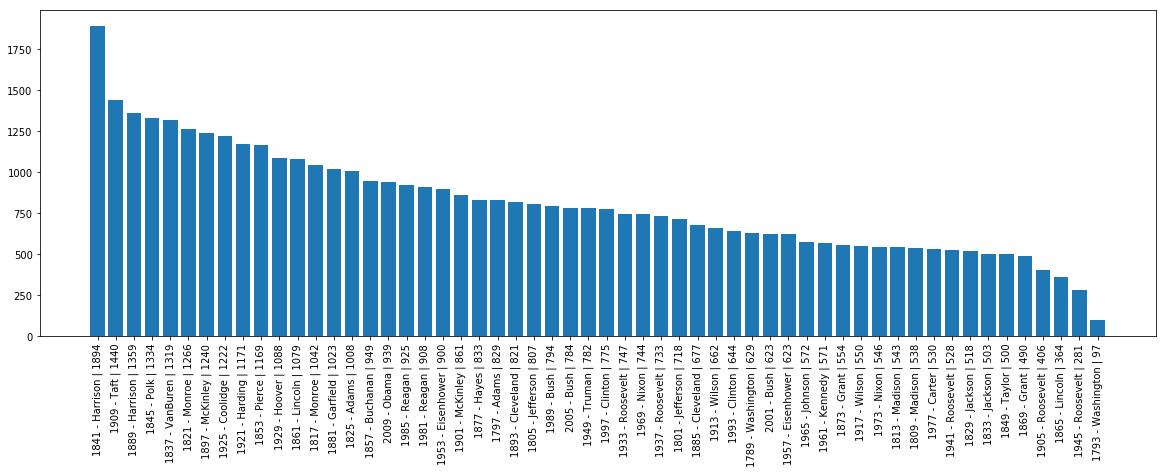

Max: 1841 - Harrison | 1894
Min: 1793 - Washington | 97


Results for state_union and ngrams


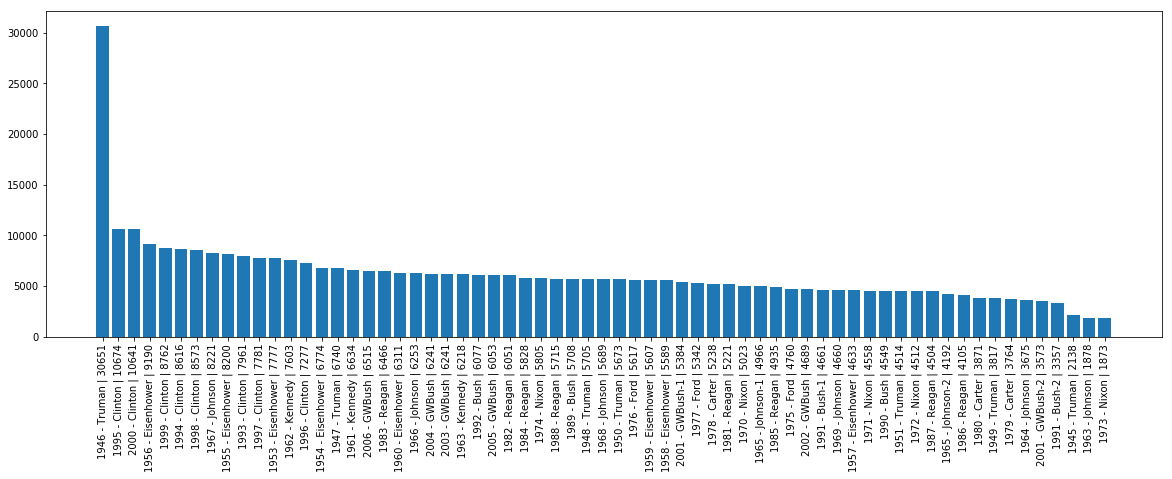

Max: 1946 - Truman | 30651
Min: 1973 - Nixon | 1873 


Results for state_union and vocab


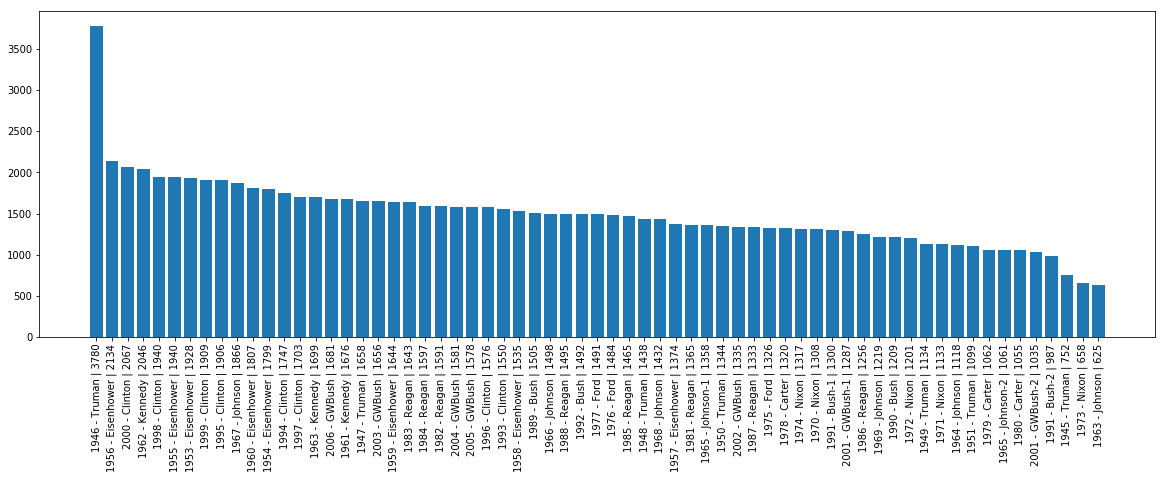

Max: 1946 - Truman | 3780
Min: 1963 - Johnson | 625


In [12]:
print("\n\nResults for inaugural and ngrams")
run_exo1(inaugural, "ngrams")

print("\n\nResults for inaugural and vocab")
run_exo1(inaugural, "vocab")

print("\n\nResults for state_union and ngrams")
run_exo1(state_union, "ngrams")

print("\n\nResults for state_union and vocab")
run_exo1(state_union, "vocab")

# 3. Building a Language Model

In [13]:
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.util import bigrams, everygrams
from nltk.lm import MLE

Introduce padding to tell the model what the boundaries of the sentence.

The module `lm` also need a flattened list of symbols to build the vocabulary

In [14]:
sentence = "My super sentence to test.".split()
print(list(pad_both_ends(sentence, n=2)))
print(list(bigrams(pad_both_ends(sentence, n=2))))
print(list(flatten(pad_both_ends(sentence, n=2))))

['<s>', 'My', 'super', 'sentence', 'to', 'test.', '</s>']
[('<s>', 'My'), ('My', 'super'), ('super', 'sentence'), ('sentence', 'to'), ('to', 'test.'), ('test.', '</s>')]
['<', 's', '>', 'M', 'y', 's', 'u', 'p', 'e', 'r', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', 't', 'o', 't', 'e', 's', 't', '.', '<', '/', 's', '>']


The method `padded_everygram_pipeline` produces the two at the same time and returns:
- an iterator over text as ngrams
- an iterator over text as vocabulary

In [15]:
train, vocab = padded_everygram_pipeline(2, inaugural.sents())

The following probabilities are not smoothed since we used a MLE model. For better results, models with smoothing are available:
- `nltk.lm.Lidstone` (requires the gamma parameter to increase scores)
- `nltk.lm.Laplace` (add 1)
- `nltk.lm.KneserNeyInterpolate`

In [16]:
my_lm = MLE(2)
my_lm.fit(train, vocab)

In [17]:
print(my_lm.counts['America'])
print(my_lm.counts[['bless']]['America'])
print(my_lm.score('the'))
print(my_lm.score('America'))
print(my_lm.score("America", ["bless"]))

192
2
0.05969602047970361
0.0012349570016273132
0.125


## Exercise 2

In [18]:
from nltk.lm import Lidstone, Laplace, KneserNeyInterpolated

In [19]:
train, vocab = padded_everygram_pipeline(2, state_union.sents())
my_mle = MLE(2)
my_mle.fit(train, vocab)
print(my_mle.counts['America'])
print(my_mle.counts[['bless']]['America'])
print(my_mle.score('the'))
print(my_mle.score('America'))
print(my_mle.score("America", ["bless"]))

1076
12
0.044047474230471735
0.0024696515174815062
0.3


In [20]:
train, vocab = padded_everygram_pipeline(2, state_union.sents())
my_lidstone = Lidstone(order=2, gamma=0.1)
my_lidstone.fit(train, vocab)
print(my_lidstone.counts['America'])
print(my_lidstone.counts[['bless']]['America'])
print(my_lidstone.score('the'))
print(my_lidstone.score('America'))
print(my_lidstone.score("America", ["bless"]))

1076
12
0.043900682629067815
0.002461637143110081
0.008071509572410112


In [21]:
train, vocab = padded_everygram_pipeline(2, state_union.sents())
my_laplace = Laplace(2)
my_laplace.fit(train, vocab)
print(my_laplace.counts['America'])
print(my_laplace.counts[['bless']]['America'])
print(my_laplace.score('the'))
print(my_laplace.score('America'))
print(my_laplace.score("America", ["bless"]))

1076
12
0.0426223683041663
0.002391845074176068
0.0008885243660720388


In [22]:
from nltk.lm import KneserNeyInterpolated
train, vocab = padded_everygram_pipeline(2, state_union.sents())
my_kneser = KneserNeyInterpolated(2)
my_kneser.fit(train, vocab)
print(my_kneser.counts['America'])
print(my_kneser.counts[['bless']]['America'])
print(my_kneser.score('the'))
print(my_kneser.score('America'))
print(my_kneser.score("America", ["bless"]))

1076
12
6.853539853334247e-05
6.853539853334247e-05
0.29750137070797067


# 4. Generation

## Exercise 3

In [23]:
print(my_mle.generate(7))
print(my_mle.generate(10))
print(my_mle.generate(30))

['<s>', 'Expenditures', 'for', 'the', 'rich', 'to', 'insure']
['trade', 'without', 'those', 'without', 'putting', 'our', 'schools', 'damaged', 'in', 'Western']
['produced', 'a', 'man', 'who', 'educate', 'themselves', '.', '</s>', 'special', 'accounts', 'that', 'has', 'become', 'computer', 'systems', ';', '30', 'billion', 'or', 'for', 'our', 'armed', 'forces', '.', '</s>', '.', '</s>', '.', '</s>', ',']


In [24]:
def clean_str(fieldid):
    fieldid = fieldid[5:-3]
    for char in list(range(10))+["-","."]:
        fieldid = fieldid.replace(str(char),"")
    return fieldid

Merge the datasets to have the largest data as possible

In [25]:
all_sentences_by_pres = dict()

for fieldid in state_union.fileids():
    pres = clean_str(fieldid)
    if pres not in all_sentences_by_pres:
        all_sentences_by_pres[pres] = state_union.sents(fieldid)
    else:
        all_sentences_by_pres[pres] += state_union.sents(fieldid)

for fieldid in inaugural.fileids():
    pres = clean_str(fieldid)
    if pres not in all_sentences_by_pres:
        all_sentences_by_pres[pres] = inaugural.sents(fieldid)
    else:
        all_sentences_by_pres[pres] += inaugural.sents(fieldid)

In [26]:
models = dict()
orders = [2,5]

for pres, sents in all_sentences_by_pres.items():
    models[pres] = dict()
    print(pres)
    for order in orders:
        train, vocab = padded_everygram_pipeline(order, sents)
        mle_model = MLE(order)
        mle_model.fit(train, vocab)
        models[pres][order] = mle_model

Truman
Eisenhower
Kennedy
Johnson
Nixon
Ford
Carter
Reagan
Bush
Clinton
GWBush
Washington
Adams
Jefferson
Madison
Monroe
Jackson
VanBuren
Harrison
Polk
Taylor
Pierce
Buchanan
Lincoln
Grant
Hayes
Garfield
Cleveland
McKinley
Roosevelt
Taft
Wilson
Harding
Coolidge
Hoover
Obama


In [27]:
for pres, value in models.items():
    for order in orders:
        print("{:10s} | {} | {}".format(pres, order, ' '.join(list(value[order].generate(15)))))
    print("\n")

Truman     | 2 | , businesses . </s> in our entire tax reduction measure of land . </s> <s>
Truman     | 5 | an early date . </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


Eisenhower | 2 | -- by the strategic change and spirit , admittedly still burns within the earth and
Eisenhower | 5 | confidence of people all over the world who are weary of tensions and armaments .


Kennedy    | 2 | give the path to new appropriations for tax levels . </s> skills over the State
Kennedy    | 5 | </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


Johnson    | 2 | , I felt -- and men dying in many nations to Vietnam , rather because
Johnson    | 5 | have dropped no bombs in North Vietnam . </s> </s> </s> </s> </s> </s> </s>


Nixon      | 2 | promote better angels of opinion , but more fairly in this occasion that will deliver
Nixon      | 5 | back to the peopleĄXin which government at all levels . </s> </s> </s> </s> </s>


Ford       | 2 | and to all levels in Fe

## Exercise 4

In [28]:
# Use Plaidml backend on MacBook Pro AMD
#import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [29]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

Using TensorFlow backend.


In [30]:
tokenizer = Tokenizer()

def dataset_preparation(data):
    corpus = data.lower().split("\n")
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len, total_words

def create_model(predictors, label, max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    model.add(Embedding(total_words, 10, input_length=input_len)) #Input Layer : Takes the sequence of words as input
    model.add(LSTM(150)) #LSTM Layer : Computes the output using LSTM units. I have added 100 units in the layer, but this number can be fine tuned later.
    model.add(Dropout(0.1)) #Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting.
    model.add(Dense(total_words, activation='softmax')) #Output Layer : Computes the probability of the best possible next word as output
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(predictors, label, epochs=100, verbose=1)
    return model

def generate_text(seed_text, next_words, max_sequence_len, model):
    for j in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=
                             max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [32]:
all_raw_by_pres = dict()

for fieldid in state_union.fileids():
    pres = clean_str(fieldid)
    if pres not in all_raw_by_pres:
        all_raw_by_pres[pres] = state_union.raw(fieldid)
    else:
        all_raw_by_pres[pres] += state_union.raw(fieldid)

for fieldid in inaugural.fileids():
    pres = clean_str(fieldid)
    if pres not in all_raw_by_pres:
        all_raw_by_pres[pres] = inaugural.raw(fieldid)
    else:
        all_raw_by_pres[pres] += inaugural.raw(fieldid)

all_raw = state_union.raw() + inaugural.raw()

In [ ]:
X, Y, msl, total_words = dataset_preparation(all_raw)
model = create_model(X, Y, msl, total_words)

In [33]:
X, Y, msl, total_words = dataset_preparation(all_raw_by_pres["Obama"])
model_obama = create_model(X, Y, msl, total_words)

Epoch 1/100
2363/2363 [==============================] - 9s 4ms/step - loss: 6.3374
Epoch 2/100
2363/2363 [==============================] - 8s 3ms/step - loss: 5.8820
Epoch 3/100
2363/2363 [==============================] - 8s 3ms/step - loss: 5.8168
Epoch 4/100
2363/2363 [==============================] - 8s 4ms/step - loss: 5.7465
Epoch 5/100
2363/2363 [==============================] - 8s 4ms/step - loss: 5.6724
Epoch 6/100
2363/2363 [==============================] - 9s 4ms/step - loss: 5.6046
Epoch 7/100
2363/2363 [==============================] - 9s 4ms/step - loss: 5.5388
Epoch 8/100
2363/2363 [==============================] - 9s 4ms/step - loss: 5.4518
Epoch 9/100
2363/2363 [==============================] - 8s 4ms/step - loss: 5.3749
Epoch 10/100
2363/2363 [==============================] - 9s 4ms/step - loss: 5.2869
Epoch 11/100
2363/2363 [==============================] - 9s 4ms/step - loss: 5.4607
Epoch 12/100
2363/2363 [==============================] - 9s 4ms/step - lo

In [34]:
print("For all presidents\n")
for i in range(10):
    print(generate_text("The best", 15, msl, model))
print("\n\nFor B. Obama\n")
print(generate_text("The best", 15, msl, model))
print(generate_text("I am", 15, msl, model))
print(generate_text("The country", 15, msl, model))
print(generate_text("France", 15, msl, model))
print(generate_text("Most people", 15, msl, model))
print(generate_text("Our ennemies", 15, msl, model))
print(generate_text("My fellow comrades", 15, msl, model))
print(generate_text("Apple is", 15, msl, model))
print(generate_text("Yes we", 15, msl, model))
print(generate_text("His parents", 15, msl, model))

SyntaxError: invalid syntax (<ipython-input-34-a30ff5168686>, line 2)

In [41]:
print("\n\nFor B. Obama\n")
print(generate_text("The best", 15, msl, model_obama))
print(generate_text("I am", 15, msl, model_obama))
print(generate_text("The country", 15, msl, model_obama))
print(generate_text("France", 15, msl, model_obama))
print(generate_text("Most people", 15, msl, model_obama))
print(generate_text("Our ennemies", 15, msl, model_obama))
print(generate_text("My fellow comrades", 15, msl, model_obama))
print(generate_text("Apple is", 15, msl, model_obama))
print(generate_text("Yes we", 15, msl, model_obama))
print(generate_text("His parents", 15, msl, model_obama))



For B. Obama

The best keepers of our liberty and understand but greatness are will end to brave once more
I am challenges is the horizon of our liberty and understand but greatness are will end to
The country world our nation in the coldest of months a small band of patriots huddled by
France the keepers of our liberty and understand but greatness are will end to brave once
Most people the price of our common dangers in the knowledge of workers across our power cannot
Our ennemies challenges may be new the instruments of our safety and good for the next alarmed
My fellow comrades citizens continue today we remain the most prosperous powerful nation on the coldest of months
Apple is the muslim world of our common dangers can have spoken during band of prosperity of
Yes we day is the fallen world between our common dangers with we spoken during rising tides
His parents four americans have today taken the presidential oath the words have been spoken during rising


# Authorship attribution

## Exercise 5

## Question 5a

In [30]:
from tqdm import tqdm_notebook as tqdm
from scipy.stats import entropy

In [26]:
all_sentences_by_pres_state_union = dict()

for fieldid in state_union.fileids():
    pres = clean_str(fieldid)
    if pres not in all_sentences_by_pres_state_union:
        all_sentences_by_pres_state_union[pres] = state_union.sents(fieldid)
    else:
        all_sentences_by_pres_state_union[pres] += state_union.sents(fieldid)

In [27]:
models = dict()
orders = [1,2,3]

for pres, sents in all_sentences_by_pres_state_union.items():
    models[pres] = dict()
    print(pres)
    for order in orders:
        train, vocab = padded_everygram_pipeline(order, sents)
        laplace_model = Laplace(order)
        laplace_model.fit(train, vocab)
        models[pres][order] = laplace_model

Truman
Eisenhower
Kennedy
Johnson
Nixon
Ford
Carter
Reagan
Bush
Clinton
GWBush


In [29]:
word_proba_by_pres = dict()
vocab = Vocabulary(state_union.words(), unk_cutoff=5)

for pres, model in models.items():
    print(pres)
    word_proba_by_pres[pres] = []
    for word in tqdm(vocab):
        word_proba_by_pres[pres].append(model[1].score(word))

Truman



Eisenhower



Kennedy



Johnson



Nixon



Ford



Carter



Reagan



Bush



Clinton



GWBush


In [31]:
kl_by_pres_couple = dict()

for pres1, proba1 in word_proba_by_pres.items():
    for pres2, proba2 in word_proba_by_pres.items():
        if pres1 is not pres2:
            key = tuple(sorted((pres1,pres2)))
            if key not in kl_by_pres_couple:
                kl_by_pres_couple[key]= entropy(proba1,proba2)

In [32]:
import operator
kl_by_pres_couple = sorted(kl_by_pres_couple.items(), key=operator.itemgetter(1))

print(kl_by_pres_couple)

[(('Bush', 'Reagan'), 0.13561982679401094), (('Eisenhower', 'Truman'), 0.15520225855242428), (('Carter', 'Ford'), 0.1683426167582902), (('Eisenhower', 'Kennedy'), 0.18308115440582853), (('Johnson', 'Reagan'), 0.18480387384157568), (('Ford', 'Nixon'), 0.18735809086141245), (('Clinton', 'Reagan'), 0.18994328362159424), (('Bush', 'Clinton'), 0.19560645883820174), (('Ford', 'Kennedy'), 0.19654458603775551), (('Bush', 'Johnson'), 0.2002222064263302), (('Carter', 'Kennedy'), 0.20311966886014243), (('Ford', 'Johnson'), 0.20371276787328757), (('Johnson', 'Nixon'), 0.20639540428136702), (('Johnson', 'Kennedy'), 0.20820393761314127), (('Bush', 'Carter'), 0.21435653051972203), (('Carter', 'Nixon'), 0.21505577526862044), (('Carter', 'Reagan'), 0.21568761165632486), (('Bush', 'GWBush'), 0.21784371087455745), (('Eisenhower', 'Ford'), 0.2183589850548908), (('Carter', 'Johnson'), 0.21954902990564068), (('Nixon', 'Reagan'), 0.21989030390653508), (('Eisenhower', 'Johnson'), 0.22069904572150548), (('Ford

In [33]:
most_similar = kl_by_pres_couple[0]
most_dissimilar = kl_by_pres_couple[-1]
print("Most similar presidents:    {:10s} and {} | {}".format(most_similar[0][0], most_similar[0][1], most_similar[1]))
print("Most dissimilar presidents: {:10s} and {} | {}".format(most_dissimilar[0][0], most_dissimilar[0][1], most_dissimilar[1]))

Most similar presidents:    Bush       and Reagan | 0.13561982679401094
Most dissimilar presidents: Clinton    and Truman | 0.46250418095810664


### Question 5b

Given author candidates A = {a1 . . . aj }, it is straightforward to build a model for each author by aggregating the training documents. We can build a model for an unattributed document in the same way. We can then determine the author model that is most similar to the model of the unknown document, by calculating KLD values between author models and unknown documents to identify the target author for which the KLD value is the smallest.

In [35]:
models_inaugural = dict()

for fieldid in inaugural.fileids():
    models_inaugural[fieldid] = dict()
    print(fieldid)
    for order in orders:
        train, vocab = padded_everygram_pipeline(order, inaugural.sents(fieldid))
        laplace_model = Laplace(order)
        laplace_model.fit(train, vocab)
        models_inaugural[fieldid][order] = laplace_model

1789-Washington.txt
1793-Washington.txt
1797-Adams.txt
1801-Jefferson.txt
1805-Jefferson.txt
1809-Madison.txt
1813-Madison.txt
1817-Monroe.txt
1821-Monroe.txt
1825-Adams.txt
1829-Jackson.txt
1833-Jackson.txt
1837-VanBuren.txt
1841-Harrison.txt
1845-Polk.txt
1849-Taylor.txt
1853-Pierce.txt
1857-Buchanan.txt
1861-Lincoln.txt
1865-Lincoln.txt
1869-Grant.txt
1873-Grant.txt
1877-Hayes.txt
1881-Garfield.txt
1885-Cleveland.txt
1889-Harrison.txt
1893-Cleveland.txt
1897-McKinley.txt
1901-McKinley.txt
1905-Roosevelt.txt
1909-Taft.txt
1913-Wilson.txt
1917-Wilson.txt
1921-Harding.txt
1925-Coolidge.txt
1929-Hoover.txt
1933-Roosevelt.txt
1937-Roosevelt.txt
1941-Roosevelt.txt
1945-Roosevelt.txt
1949-Truman.txt
1953-Eisenhower.txt
1957-Eisenhower.txt
1961-Kennedy.txt
1965-Johnson.txt
1969-Nixon.txt
1973-Nixon.txt
1977-Carter.txt
1981-Reagan.txt
1985-Reagan.txt
1989-Bush.txt
1993-Clinton.txt
1997-Clinton.txt
2001-Bush.txt
2005-Bush.txt
2009-Obama.txt


In [38]:
authorship_attribution = dict()

for fieldid in tqdm(inaugural.fileids()):
    current_pres = clean_str(fieldid)
    
    if current_pres in models:
        print(fieldid)
        vocab = Vocabulary(inaugural.words(fieldid), unk_cutoff=3)
        authorship_attribution[fieldid] = []

        current_score = [models_inaugural[fieldid][1].score(word) for word in vocab]

        pres_kl = []

        for pres, model in models.items():
            pres_scores = [model[1].score(word) for word in vocab]
            pres_kl.append((entropy(current_score,pres_scores),pres))

        authorship_attribution[fieldid] = sorted(pres_kl)[0]

1949-Truman.txt
1953-Eisenhower.txt
1957-Eisenhower.txt
1961-Kennedy.txt
1965-Johnson.txt
1969-Nixon.txt
1973-Nixon.txt
1977-Carter.txt
1981-Reagan.txt
1985-Reagan.txt
1989-Bush.txt
1993-Clinton.txt
1997-Clinton.txt
2001-Bush.txt
2005-Bush.txt


In [47]:
print("Attribution of the texts:")
accuracy_attribution = []

for fileid, res in authorship_attribution.items():
    curr_pres = clean_str(fileid)
    pres = res[1]
    equal = curr_pres == pres
    accuracy_attribution.append(equal)
    print("  {:5s} | {:20s} | {:12s} | {}".format(str(equal), fileid, pres, res[0]))

print("Accuracy: {}".format(np.mean(accuracy_attribution)))

Attribution of the texts:
  False | 1949-Truman.txt      | Eisenhower   | 0.224587472127727
  True  | 1953-Eisenhower.txt  | Eisenhower   | 0.20741612477192864
  False | 1957-Eisenhower.txt  | Kennedy      | 0.2472863768244922
  False | 1961-Kennedy.txt     | Johnson      | 0.2894795427983745
  True  | 1965-Johnson.txt     | Johnson      | 0.2519890167918344
  False | 1969-Nixon.txt       | Johnson      | 0.22908180534566971
  False | 1973-Nixon.txt       | Reagan       | 0.31042189280604393
  True  | 1977-Carter.txt      | Carter       | 0.23368336905655565
  True  | 1981-Reagan.txt      | Reagan       | 0.16718372949485386
  True  | 1985-Reagan.txt      | Reagan       | 0.15107288138399178
  True  | 1989-Bush.txt        | Bush         | 0.20875825137631038
  False | 1993-Clinton.txt     | Bush         | 0.2523597172751155
  False | 1997-Clinton.txt     | Bush         | 0.19956298248924623
  False | 2001-Bush.txt        | GWBush       | 0.2239745242587436
  False | 2005-Bush.txt      

### Question 5c

In [48]:
similarity_old = dict()

for fieldid in tqdm(inaugural.fileids()):
    current_pres = clean_str(fieldid)

    if current_pres not in models:
        print(fieldid)
        vocab = Vocabulary(inaugural.words(fieldid), unk_cutoff=3)
        similarity_old[fieldid] = []

        current_score = [models_inaugural[fieldid][1].score(word) for word in vocab]

        pres_kl = []

        for pres, model in models.items():
            pres_scores = [model[1].score(word) for word in vocab]
            pres_kl.append((entropy(current_score,pres_scores),pres))

        similarity_old[fieldid] = sorted(pres_kl)[0]

1789-Washington.txt
1793-Washington.txt
1797-Adams.txt
1801-Jefferson.txt
1805-Jefferson.txt
1809-Madison.txt
1813-Madison.txt
1817-Monroe.txt
1821-Monroe.txt
1825-Adams.txt
1829-Jackson.txt
1833-Jackson.txt
1837-VanBuren.txt
1841-Harrison.txt
1845-Polk.txt
1849-Taylor.txt
1853-Pierce.txt
1857-Buchanan.txt
1861-Lincoln.txt
1865-Lincoln.txt
1869-Grant.txt
1873-Grant.txt
1877-Hayes.txt
1881-Garfield.txt
1885-Cleveland.txt
1889-Harrison.txt
1893-Cleveland.txt
1897-McKinley.txt
1901-McKinley.txt
1905-Roosevelt.txt
1909-Taft.txt
1913-Wilson.txt
1917-Wilson.txt
1921-Harding.txt
1925-Coolidge.txt
1929-Hoover.txt
1933-Roosevelt.txt
1937-Roosevelt.txt
1941-Roosevelt.txt
1945-Roosevelt.txt
2009-Obama.txt


In [49]:
print("Simalirty of the texts of old presidents with new presidents:")

for fileid, res in similarity_old.items():
    print("  {:20s} | {:12s} | {}".format(fileid, res[1], res[0]))

Simalirty of the texts of old presidents with new presidents:
  1789-Washington.txt  | Ford         | 0.29921397829590096
  1793-Washington.txt  | Nixon        | 0.26633318781010296
  1797-Adams.txt       | Ford         | 0.322542039366051
  1801-Jefferson.txt   | Johnson      | 0.2736266374703082
  1805-Jefferson.txt   | Kennedy      | 0.3699371159422185
  1809-Madison.txt     | Kennedy      | 0.2380701708243708
  1813-Madison.txt     | Truman       | 0.2715376218056452
  1817-Monroe.txt      | Carter       | 0.2823109628564091
  1821-Monroe.txt      | Eisenhower   | 0.3296395405455642
  1825-Adams.txt       | Eisenhower   | 0.30145535407191304
  1829-Jackson.txt     | Truman       | 0.231303979279852
  1833-Jackson.txt     | Ford         | 0.31112748560714576
  1837-VanBuren.txt    | Ford         | 0.2871794456781015
  1841-Harrison.txt    | Ford         | 0.3363881786839984
  1845-Polk.txt        | Ford         | 0.33931345947297575
  1849-Taylor.txt      | Eisenhower   | 0.29055836